In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

# --------------------------------------------------------
# Reproducibility
# --------------------------------------------------------
RANDOM_STATE = 42

# --------------------------------------------------------
# Load Data
# --------------------------------------------------------
df = pd.read_csv("../../data/train_set.csv")

target = "NObeyesdad"

# --------------------------------------------------------
# Remove EDA-identified multicollinear features
# --------------------------------------------------------
cols_to_drop = ["CH2O", "Height", "Weight"]  # adjust if spelling differs in CSV
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

df = df.drop(columns=cols_to_drop)

# --------------------------------------------------------
# Split X/y
# --------------------------------------------------------
X = df.drop(columns=[target])   # Remove target variable from predictors
y = df[target]

# --------------------------------------------------------
# Internal Train/Test Split (80/20)
# --------------------------------------------------------
X_train, X_test_internal, y_train, y_test_internal = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

# --------------------------------------------------------
# Identify Features (after dropping multicollinear columns)
# --------------------------------------------------------
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()

# --------------------------------------------------------
# Preprocessing Pipeline
# --------------------------------------------------------
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# --------------------------------------------------------
# Logistic Regression Pipeline
# --------------------------------------------------------
logreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=5000,
        multi_class="multinomial",
        solver="saga",
        random_state=RANDOM_STATE
    ))
])

# --------------------------------------------------------
# Hyperparameter Grid (Ridge, Lasso, ElasticNet)
# --------------------------------------------------------
param_grid = [
    {"clf__penalty": ["l2"], "clf__C": [0.01, 0.1, 1, 5, 10]},
    {"clf__penalty": ["l1"], "clf__C": [0.01, 0.1, 1, 5, 10]},
    {
        "clf__penalty": ["elasticnet"],
        "clf__C": [0.01, 0.1, 1, 5, 10],
        "clf__l1_ratio": [0.1, 0.5, 0.9]
    }
]

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

# --------------------------------------------------------
# Fit on training set
# --------------------------------------------------------
grid.fit(X_train, y_train)

best_logreg = grid.best_estimator_
best_params = grid.best_params_

print("Best Parameters:", best_params)

# --------------------------------------------------------
# Internal Test Evaluation
# --------------------------------------------------------
y_pred_internal = best_logreg.predict(X_test_internal)

internal_acc = accuracy_score(y_test_internal, y_pred_internal)
internal_f1 = f1_score(y_test_internal, y_pred_internal, average="macro")

print("\nInternal Test Accuracy:", internal_acc)
print("Internal Test F1 Score:", internal_f1)

# --------------------------------------------------------
# CV results for reporting
# --------------------------------------------------------
cv_results = (
    pd.DataFrame(grid.cv_results_)[["params", "mean_test_score", "std_test_score"]]
    .sort_values(by="mean_test_score", ascending=False)
)

cv_results.head()


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'clf__C': 10, 'clf__penalty': 'l1'}

Internal Test Accuracy: 0.6005917159763313
Internal Test F1 Score: 0.5905312307599104


,params,mean_test_score,std_test_score
9,"{'clf__C': 10, 'clf__penalty': 'l1'}",0.590102,0.032281
24,"{'clf__C': 10, 'clf__l1_ratio': 0.9, 'clf__pen...",0.588896,0.033659
21,"{'clf__C': 5, 'clf__l1_ratio': 0.9, 'clf__pena...",0.588057,0.024854
4,"{'clf__C': 10, 'clf__penalty': 'l2'}",0.587719,0.031179
23,"{'clf__C': 10, 'clf__l1_ratio': 0.5, 'clf__pen...",0.587717,0.031171


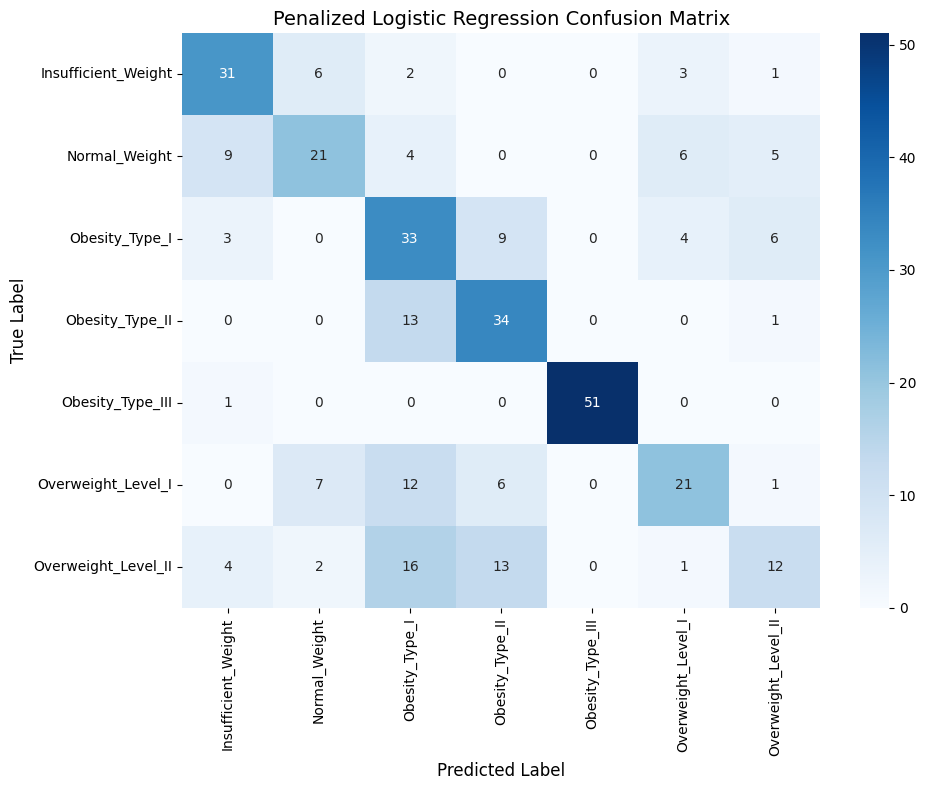

Saved penalized_confusion_matrix.png to OUTPUT folder.


In [27]:


# --------------------------------------------------------
# Generate Confusion Matrix
# --------------------------------------------------------
cm = confusion_matrix(y_test_internal, y_pred_internal)
labels = sorted(y_test_internal.unique())  # ensures consistent order

# --------------------------------------------------------
# Styled Plot (Matches NN Formatting)
# --------------------------------------------------------
plt.figure(figsize=(10, 8))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Penalized Logistic Regression Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# --------------------------------------------------------
# Save to OUTPUT Folder
# --------------------------------------------------------
os.makedirs("../../OUTPUT", exist_ok=True)
plt.savefig("../../OUTPUT/penalized_confusion_matrix.png", dpi=300)

plt.show()
print("Saved penalized_confusion_matrix.png to OUTPUT folder.")


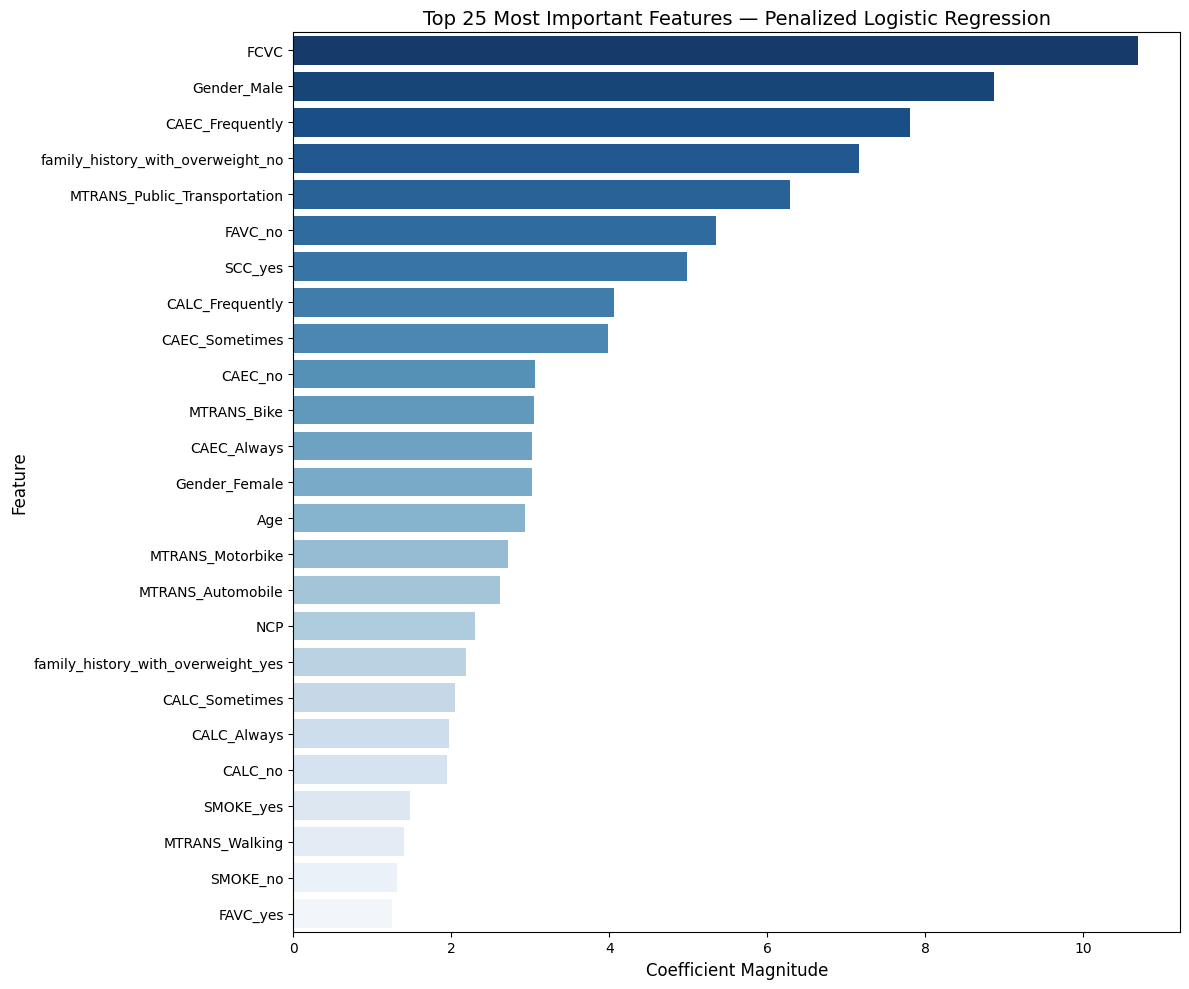

Saved penalized_coefficient_plot.png to OUTPUT folder.


In [28]:
# --------------------------------------------------------
# Coefficient Plot for Penalized Logistic Regression
# --------------------------------------------------------

# Extract the preprocessing object and the trained classifier
preproc = best_logreg.named_steps["preprocess"]
clf_model = best_logreg.named_steps["clf"]

# Recover feature names from ColumnTransformer
num_features = preproc.named_transformers_["num"].get_feature_names_out()
cat_features = preproc.named_transformers_["cat"].get_feature_names_out()

all_feature_names = np.concatenate([num_features, cat_features])

# Coefficients have shape (n_classes, n_features)
# For interpretability, take the L2 norm across classes
coef_matrix = clf_model.coef_
coef_magnitude = np.linalg.norm(coef_matrix, axis=0)

# Build a DataFrame
coef_df = pd.DataFrame({
    "Feature": all_feature_names,
    "CoefficientMagnitude": coef_magnitude
})

# Sort by magnitude (largest = most influential)
coef_df = coef_df.sort_values(by="CoefficientMagnitude", ascending=False)

# --------------------------------------------------------
# Plot
# --------------------------------------------------------
plt.figure(figsize=(12, 10))

sns.barplot(
    data=coef_df.head(25),  # top 25 most important
    x="CoefficientMagnitude",
    y="Feature",
    palette="Blues_r"
)

plt.title("Top 25 Most Important Features — Penalized Logistic Regression", fontsize=14)
plt.xlabel("Coefficient Magnitude", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()

# --------------------------------------------------------
# Save to OUTPUT Folder
# --------------------------------------------------------
os.makedirs("../../OUTPUT", exist_ok=True)
plt.savefig("../../OUTPUT/penalized_coefficient_plot.png", dpi=300)

plt.show()

print("Saved penalized_coefficient_plot.png to OUTPUT folder.")
